In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 276, done.
remote: Counting objects: 100% (276/276), done.
remote: Compressing objects: 100% (238/238), done.
remote: Total 276 (delta 103), reused 170 (delta 32), pack-reused 0
Receiving objects: 100% (276/276), 11.63 MiB | 14.92 MiB/s, done.
Resolving deltas: 100% (103/103), done.


In [2]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 24.3 MB/s eta 0:00:00


In [3]:
! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorizationImpressions_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorizationImpressions_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorizationImpressions_Cython_Epoch.c: In functio

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv
/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv
/kaggle/input/hyperparameters-tuning/__results__.html
/kaggle/input/hyperparameters-tuning/tuning.db
/kaggle/input/hyperparameters-tuning/__notebook__.ipynb
/kaggle/input/hyperparameters-tuning/__output__.json
/kaggle/input/hyperparameters-tuning/best_params_ials.json
/kaggle/input/hyperparameters-tuning/custom.css
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/run_all_algorithms.py
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/cython_example_FunkSVD.py
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/LICENSE
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/.gitignore
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/README.md
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/run_hyperparameter_search.py
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/cython_examp

# Configurations

In [5]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [6]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [7]:
from os import system, getpid, walk
from psutil import Process
from colorama import Fore, Style, init
from IPython.display import display, HTML

def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    print(style + color + text + Style.RESET_ALL)
    
def GetMemUsage():   
    pid = getpid()
    py = Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return f"RAM memory GB usage = {memory_use :.4}"

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.216


In [8]:
config = {
    'tune_parameters_item_knn': True,
    'tune_parameters_user_knn': False,
    'tune_parameters_pure_svd': False,
    'tune_parameters_ials': False,
    'database_path': '/kaggle/working/tuning.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': False,
    'train_best_models': False,
    'copy_prev_best_models': False,
    'submit': False,
    'save_github': True
}

In [9]:
try:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/tuning_results/tuning.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass # if not present optuna will create it

# Data Import

In [10]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [11]:
train_data.head(5)

,row,col,data
0,1,7,1.0
1,1,15,1.0
2,1,16,1.0
3,1,133,1.0
4,1,161,1.0


In [12]:
user_ids_test.head(5)

,user_id
0,1
1,2
2,3
3,4
4,5


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478730 entries, 0 to 478729
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   row     478730 non-null  int64  
 1   col     478730 non-null  int64  
 2   data    478730 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 11.0 MB


In [14]:
train_data.describe()

,row,col,data
count,478730.000000,478730.000000,478730.0
mean,6477.521302,4101.952798,1.0
std,3738.435208,5388.639634,0.0
min,1.000000,1.000000,1.0
25%,3204.000000,315.000000,1.0
50%,6493.000000,1575.000000,1.0
75%,9715.000000,5879.000000,1.0
max,13024.000000,22347.000000,1.0


In [15]:
n_users_train = train_data.row.max()
n_users_test = len(user_ids_test.user_id.unique())

print(f'Train number of users: {n_users_train}')
print(f'Test number of users: {n_users_test}')

Train number of users: 13024
Test number of users: 10882


In [16]:
number_of_items = train_data.col.max()

print(f'Number of items: {number_of_items}')

Number of items: 22347


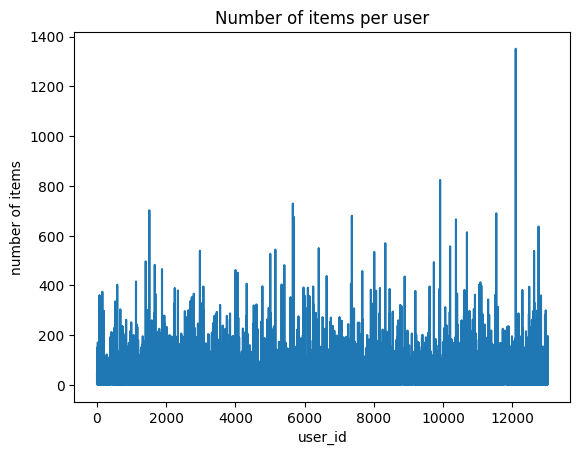

In [17]:
train_data.groupby('row').count().col.plot()
plt.xlabel('user_id')
plt.ylabel('number of items')
plt.title('Number of items per user');

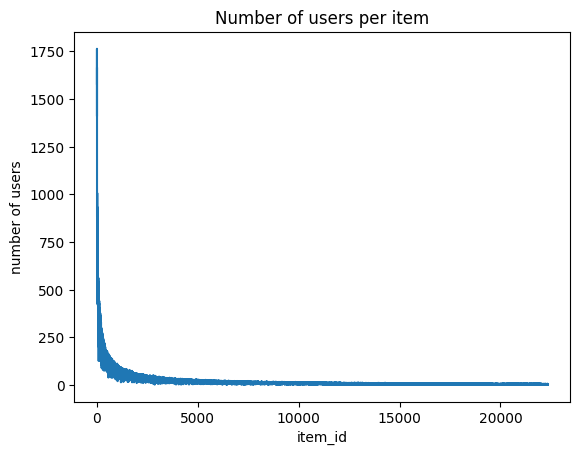

In [18]:
train_data.groupby('col').count().row.plot()
plt.xlabel('item_id')
plt.ylabel('number of users')
plt.title('Number of users per item');

In [19]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

# Cross Validation Split

In [20]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [21]:
from Data_manager.IncrementalSparseMatrix import IncrementalSparseMatrix


class CrossValidationSplitter:
    def __init__(self, n_splits):
        self.n_splits = n_splits
        self.folds = []
        
    def split(self, URM):
        n_int_per_split = int(URM.nnz / self.n_splits)
        indices = np.arange(0, URM.nnz, 1)
        np.random.shuffle(indices)
        num_users, num_items = URM.shape
        
        URM_all = sps.coo_matrix(URM)
        
        for i in range(self.n_splits):
            if i == self.n_splits - 1:
                indices_valid = indices[n_int_per_split * i:]
                indices_train = indices[:n_int_per_split * i]
            else:
                indices_valid = indices[n_int_per_split * i: n_int_per_split * (i + 1)]
                indices_train_1 = indices[n_int_per_split * max(0, i - 1): n_int_per_split * i]
                indices_train_2 = indices[n_int_per_split * (i + 1):]
                indices_train = np.concatenate((indices_train_1, indices_train_2))
                
            URM_valid_builder = IncrementalSparseMatrix(
                n_rows=num_users, n_cols=num_items, auto_create_col_mapper=False, 
                auto_create_row_mapper=False
            )
            
            URM_train_builder = IncrementalSparseMatrix(
                n_rows=num_users, n_cols=num_items, auto_create_col_mapper=False, 
                auto_create_row_mapper=False
            )
            
            URM_valid_builder.add_data_lists(
                URM_all.row[indices_valid],
                URM_all.col[indices_valid],
                URM_all.data[indices_valid]
            )
            
            URM_train_builder.add_data_lists(
                URM_all.row[indices_train],
                URM_all.col[indices_train],
                URM_all.data[indices_train]
            )
            
            yield URM_train_builder.get_SparseMatrix(), URM_valid_builder.get_SparseMatrix()

# Experiments

In [22]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [23]:
URM_train, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_validation, URM_test = split_train_in_two_percentage_global_sample(URM_test_complete, train_percentage = 0.8)

In [24]:
# recommender = MultiThreadSLIM_SLIMElasticNetRecommender(URM_train)
# recommender.fit(l1_ratio=0.5, alpha=1, positive_only=True, topK=10)

# np.bool = bool
# np.float = float
# evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

In [25]:
# evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
# early_stopping_params = {
#     'epochs_min': 30,
#     'stop_on_validation': True,
#     'validation_every_n': 1,
#     'validation_metric': 'MAP',
#     'lower_validations_allowed': 5,
#     'evaluator_object': evaluator_validation
# }

# recommender = IALSRecommender(URM_train)
# recommender.fit(reg=1e-2, **early_stopping_params)

In [26]:
# evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

In [27]:
# recommender = PureSVDRecommender(URM_train)
# recommender.fit(num_factors=100)

# evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

In [28]:
# recommender = ItemKNNCFRecommender(URM_train)
# recommender.fit(topK=10, shrink=100)

# evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

In [29]:
# recommender = UserKNNCFRecommender(URM_train)
# recommender.fit(topK=20, shrink=10)

# evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

# Hyperparameters tuning

Not considering adjusted cosine and pearson since they remove the mean of the interactions, but here there are all interactions equal to 1

In [30]:
import sqlite3

def print_all_rows(table_name, database_path):
    # Connect to the SQLite database
    connection = sqlite3.connect(database_path)

    # Create a cursor object to execute SQL queries
    cursor = connection.cursor()

    try:
        # Fetch all rows from the specified table
        cursor.execute(f"SELECT * FROM {table_name};")

        # Fetch all rows
        rows = cursor.fetchall()

        # Print the rows
        print(f"All rows from table '{table_name}':")
        for row in rows:
            print(row)

    except sqlite3.Error as e:
        print(f"Error reading data from table '{table_name}': {e}")

    finally:
        # Close the cursor and connection
        cursor.close()
        connection.close()

# Replace 'your_table_name' with the actual table name you want to print
table_name = 'studies'
print_all_rows(table_name, config['database_path'])

All rows from table 'studies':
(1, 'hyperparameters_tuning_ials')


## Item KNN Collaborative Filtering

In [31]:
from concurrent.futures import ThreadPoolExecutor

def evaluate_item_knn(URM_train, URM_valid, similarity, topK, shrink):
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(topK=topK, shrink=shrink, similarity=similarity)

    evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
    result_df, _ = evaluator.evaluateRecommender(recommender)
    print(f'MAP is {result_df.loc[10, "MAP"]}')
    return result_df.loc[10, 'MAP']


def objective_item_knn(trial):
    similarity = trial.suggest_categorical('similarity', ["cosine", "asymmetric", "dice", "jaccard", "tanimoto", "tversky"])
    topK = trial.suggest_int('topK', 10, 1000)
    shrink = trial.suggest_int('shrink', 0, 500)
    
    results = [None] * 10
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = []
        for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
            futures.append(executor.submit(evaluate_item_knn, URM_train, URM_valid, similarity, topK, shrink))
        print(len(futures))
        for j, future in enumerate(futures):
            results[j] = future.result()
        
    return np.mean(results)

In [32]:
%%time

if config['tune_parameters_item_knn']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_knn_item', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_item_knn, n_trials=100)

[I 2023-11-21 14:05:29,806] A new study created in RDB with name: hyperparameters_tuning_knn_item


ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 597 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 235 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 767 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 925 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 568 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1151 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 864 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1441 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 14:07:36,269] Trial 0 finished with value: 0.016278208732109882 and parameters: {'similarity': 'tanimoto', 'topK': 32, 'shrink': 207}. Best is trial 0 with value: 0.016278208732109882.


MAP is 0.020058691770473397
MAP is 0.022518578844218384
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 239 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 749 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 348 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 943 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 542 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1138 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 832 ( 3.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1455 (11

[I 2023-11-21 14:09:44,007] Trial 1 finished with value: 0.014547722464969872 and parameters: {'similarity': 'jaccard', 'topK': 290, 'shrink': 371}. Best is trial 0 with value: 0.016278208732109882.


MAP is 0.0197273547343536
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 498 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 777 ( 6.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 512 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1458 (11.2%) users with no interaction

[I 2023-11-21 14:12:02,634] Trial 2 finished with value: 0.014100812923983347 and parameters: {'similarity': 'tversky', 'topK': 666, 'shrink': 328}. Best is trial 0 with value: 0.016278208732109882.


MAP is 0.019102322437598844
ItemKNNCFRecommender: URM Detected 473 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 226 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1152 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 865 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1463 (11.2%) users with no interacti

[I 2023-11-21 14:14:16,268] Trial 3 finished with value: 0.016615036395663287 and parameters: {'similarity': 'cosine', 'topK': 21, 'shrink': 84}. Best is trial 3 with value: 0.016615036395663287.


MAP is 0.02380670004088072
MAP is 0.023714664568397725
ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 607 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 222 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 332 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 936 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 508 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1126 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 846 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1460 (11.

[I 2023-11-21 14:16:34,420] Trial 4 finished with value: 0.012993659142868836 and parameters: {'similarity': 'asymmetric', 'topK': 609, 'shrink': 167}. Best is trial 3 with value: 0.016615036395663287.


MAP is 0.01816042895771872
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 503 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 220 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 767 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 352 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 534 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1168 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 884 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1409 (10.8%) users with no interactio

[I 2023-11-21 14:18:48,687] Trial 5 finished with value: 0.014880612189358874 and parameters: {'similarity': 'asymmetric', 'topK': 220, 'shrink': 79}. Best is trial 3 with value: 0.016615036395663287.


MAP is 0.02107724609168412
MAP is 0.021291606074226834
ItemKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 593 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 232 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 358 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 922 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 531 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1162 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 866 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1417 (10.

[I 2023-11-21 14:20:57,498] Trial 6 finished with value: 0.015130131661345572 and parameters: {'similarity': 'dice', 'topK': 685, 'shrink': 144}. Best is trial 3 with value: 0.016615036395663287.


MAP is 0.021410282838854235
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 738 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 361 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 927 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 913 ( 4.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1445 (11.1%) users with no interacti

[I 2023-11-21 14:23:11,572] Trial 7 finished with value: 0.014948320218513032 and parameters: {'similarity': 'jaccard', 'topK': 658, 'shrink': 154}. Best is trial 3 with value: 0.016615036395663287.


MAP is 0.02182727929881628
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 755 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 896 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 565 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1157 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 869 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1413 (10.8%) users with no interactio

[I 2023-11-21 14:25:27,584] Trial 8 finished with value: 0.014950169800186656 and parameters: {'similarity': 'asymmetric', 'topK': 376, 'shrink': 49}. Best is trial 3 with value: 0.016615036395663287.


MAP is 0.02067965488082022
ItemKNNCFRecommender: URM Detected 510 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 193 ( 0.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 628 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 773 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 383 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 934 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 556 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1155 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 930 ( 4.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1473 (11.3%) users with no interactio

[I 2023-11-21 14:27:48,922] Trial 9 finished with value: 0.014109223691193763 and parameters: {'similarity': 'tversky', 'topK': 421, 'shrink': 421}. Best is trial 3 with value: 0.016615036395663287.


MAP is 0.01922908482197995
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 593 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 347 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1112 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 861 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1449 (11.1%) users with no interactio

[I 2023-11-21 14:30:10,676] Trial 10 finished with value: 0.011616422399831218 and parameters: {'similarity': 'cosine', 'topK': 991, 'shrink': 299}. Best is trial 3 with value: 0.016615036395663287.


MAP is 0.01585964102727294
ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 464 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 731 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1149 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 865 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1437 (11.0%) users with no interactio

[I 2023-11-21 14:32:18,321] Trial 11 finished with value: 0.016137973310455658 and parameters: {'similarity': 'tanimoto', 'topK': 49, 'shrink': 226}. Best is trial 3 with value: 0.016615036395663287.


ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 725 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 379 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1097 ( 8.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 904 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1405 (10.8%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 14:34:25,382] Trial 12 finished with value: 0.015344548177199926 and parameters: {'similarity': 'tanimoto', 'topK': 32, 'shrink': 487}. Best is trial 3 with value: 0.016615036395663287.


ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 226 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 744 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 352 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 911 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 569 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1116 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 892 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1454 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 14:36:41,653] Trial 13 finished with value: 0.015991825410133626 and parameters: {'similarity': 'cosine', 'topK': 170, 'shrink': 20}. Best is trial 3 with value: 0.016615036395663287.


MAP is 0.023835112417763413
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 734 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 547 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1167 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1399 (10.7%) users with no interacti

[I 2023-11-21 14:38:58,284] Trial 14 finished with value: 0.015415238136925469 and parameters: {'similarity': 'cosine', 'topK': 12, 'shrink': 238}. Best is trial 3 with value: 0.016615036395663287.


MAP is 0.018754569702675063
MAP is 0.02111070636680383
ItemKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 185 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 157 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 577 ( 4.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 266 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 714 ( 5.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1100 ( 8.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 853 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1370 (10.

[I 2023-11-21 14:41:08,676] Trial 15 finished with value: 0.016283477161224344 and parameters: {'similarity': 'tanimoto', 'topK': 151, 'shrink': 104}. Best is trial 3 with value: 0.016615036395663287.


ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 504 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 581 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 348 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 918 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1136 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 883 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1431 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 14:43:16,805] Trial 16 finished with value: 0.016116578775563942 and parameters: {'similarity': 'dice', 'topK': 165, 'shrink': 97}. Best is trial 3 with value: 0.016615036395663287.


MAP is 0.017790026547688517
ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 596 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 246 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 750 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 907 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1142 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1431 (11.0%) users with no interacti

[I 2023-11-21 14:45:27,509] Trial 17 finished with value: 0.015646217751446676 and parameters: {'similarity': 'tanimoto', 'topK': 512, 'shrink': 106}. Best is trial 3 with value: 0.016615036395663287.


MAP is 0.020111618729805533
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 739 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 366 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 896 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 580 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1147 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 930 ( 4.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1444 (11.1%) users with no interacti

[I 2023-11-21 14:48:01,156] Trial 18 finished with value: 0.014194295846997032 and parameters: {'similarity': 'cosine', 'topK': 842, 'shrink': 4}. Best is trial 3 with value: 0.016615036395663287.


MAP is 0.022347053280263863
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 499 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 743 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 359 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 563 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1120 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 884 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1448 (11.1%) users with no interacti

[I 2023-11-21 14:50:18,048] Trial 19 finished with value: 0.014864807180549366 and parameters: {'similarity': 'tanimoto', 'topK': 292, 'shrink': 288}. Best is trial 3 with value: 0.016615036395663287.


MAP is 0.018565001272298064
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 756 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 339 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 949 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 517 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1141 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 864 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1470 (11.3%) users with no interacti

[I 2023-11-21 14:52:34,706] Trial 20 finished with value: 0.015781112486649953 and parameters: {'similarity': 'cosine', 'topK': 152, 'shrink': 64}. Best is trial 3 with value: 0.016615036395663287.


MAP is 0.022363193462203307
MAP is 0.02246065225971968
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 183 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 933 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 573 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1152 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1461 (11.

[I 2023-11-21 14:54:38,692] Trial 21 finished with value: 0.01600514074217195 and parameters: {'similarity': 'tanimoto', 'topK': 104, 'shrink': 183}. Best is trial 3 with value: 0.016615036395663287.


MAP is 0.01950490614070851
MAP is 0.01570081783405879
MAP is 0.021974406643118307
MAP is 0.022258021013400048
ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 484 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 575 ( 4.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 256 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 730 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 349 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 885 ( 6.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1086 ( 8.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 892 ( 4.0%) items with no int

[I 2023-11-21 14:56:44,799] Trial 22 finished with value: 0.01543488867579133 and parameters: {'similarity': 'tanimoto', 'topK': 259, 'shrink': 203}. Best is trial 3 with value: 0.016615036395663287.


MAP is 0.02144226553627554
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 228 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 737 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 364 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 912 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 521 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1129 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 862 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1438 (11.0%) users with no interactio

[I 2023-11-21 14:58:49,382] Trial 23 finished with value: 0.01641118821572836 and parameters: {'similarity': 'tanimoto', 'topK': 100, 'shrink': 123}. Best is trial 3 with value: 0.016615036395663287.


ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 622 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 246 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 750 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 342 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 933 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1162 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 847 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1409 (10.8%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 15:00:58,936] Trial 24 finished with value: 0.015694164586130974 and parameters: {'similarity': 'tanimoto', 'topK': 373, 'shrink': 121}. Best is trial 3 with value: 0.016615036395663287.


ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 599 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 253 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 729 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 893 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1128 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 850 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1441 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 15:03:09,244] Trial 25 finished with value: 0.017117298820292857 and parameters: {'similarity': 'tversky', 'topK': 110, 'shrink': 46}. Best is trial 25 with value: 0.017117298820292857.


ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 747 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 935 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 507 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1156 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1426 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 15:05:16,761] Trial 26 finished with value: 0.017009877661882108 and parameters: {'similarity': 'tversky', 'topK': 100, 'shrink': 52}. Best is trial 25 with value: 0.017117298820292857.


MAP is 0.02358341938973721
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 611 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 743 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 354 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 908 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1131 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1436 (11.0%) users with no interactio

[I 2023-11-21 15:07:34,280] Trial 27 finished with value: 0.01684753702617684 and parameters: {'similarity': 'tversky', 'topK': 220, 'shrink': 39}. Best is trial 25 with value: 0.017117298820292857.


ItemKNNCFRecommender: URM Detected 481 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 724 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 367 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 912 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1112 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1431 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 15:09:48,374] Trial 28 finished with value: 0.01672772935952807 and parameters: {'similarity': 'tversky', 'topK': 222, 'shrink': 37}. Best is trial 25 with value: 0.017117298820292857.


ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 504 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 340 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 527 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 849 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1426 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 15:12:09,198] Trial 29 finished with value: 0.016291328437970914 and parameters: {'similarity': 'tversky', 'topK': 462, 'shrink': 33}. Best is trial 25 with value: 0.017117298820292857.


MAP is 0.023314808680823876
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 603 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 235 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 728 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 328 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 889 ( 6.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 521 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1136 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 879 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1431 (11.0%) users with no interacti

[I 2023-11-21 15:14:22,875] Trial 30 finished with value: 0.0162912168851861 and parameters: {'similarity': 'tversky', 'topK': 356, 'shrink': 58}. Best is trial 25 with value: 0.017117298820292857.


ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 252 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 712 ( 5.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 350 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 887 ( 6.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1108 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 888 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1379 (10.6%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 15:16:33,434] Trial 31 finished with value: 0.01620752476399179 and parameters: {'similarity': 'tversky', 'topK': 222, 'shrink': 8}. Best is trial 25 with value: 0.017117298820292857.


ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 621 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 732 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 347 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 931 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 554 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1131 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 846 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1469 (11.3%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 15:18:45,126] Trial 32 finished with value: 0.017056238290106645 and parameters: {'similarity': 'tversky', 'topK': 95, 'shrink': 40}. Best is trial 25 with value: 0.017117298820292857.


MAP is 0.0210563076303817
MAP is 0.024778603012723385
MAP is 0.023664720441708476
ItemKNNCFRecommender: URM Detected 506 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 181 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 617 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 253 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 772 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 339 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 925 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 541 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1148 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
ItemKNNCFRecommen

[I 2023-11-21 15:20:56,400] Trial 33 finished with value: 0.01709859767741213 and parameters: {'similarity': 'tversky', 'topK': 96, 'shrink': 49}. Best is trial 25 with value: 0.017117298820292857.


ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 603 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 752 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1155 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 851 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1434 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 15:23:08,769] Trial 34 finished with value: 0.01679061985485906 and parameters: {'similarity': 'tversky', 'topK': 93, 'shrink': 68}. Best is trial 25 with value: 0.017117298820292857.


ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 584 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 235 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 774 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 525 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1143 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 845 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1456 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 15:25:24,004] Trial 35 finished with value: 0.01566314608233649 and parameters: {'similarity': 'tversky', 'topK': 294, 'shrink': 137}. Best is trial 25 with value: 0.017117298820292857.


MAP is 0.019904462896516675
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 921 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 570 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 855 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1475 (11.3%) users with no interacti

[I 2023-11-21 15:27:34,291] Trial 36 finished with value: 0.015307928744740578 and parameters: {'similarity': 'tversky', 'topK': 92, 'shrink': 1}. Best is trial 25 with value: 0.017117298820292857.


ItemKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 507 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 587 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 234 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 328 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 913 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 496 ( 2.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1122 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 833 ( 3.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1424 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 15:29:39,446] Trial 37 finished with value: 0.0162194109883042 and parameters: {'similarity': 'jaccard', 'topK': 65, 'shrink': 185}. Best is trial 25 with value: 0.017117298820292857.


ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 714 ( 5.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 342 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 900 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1425 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 15:31:51,882] Trial 38 finished with value: 0.016783387994016574 and parameters: {'similarity': 'tversky', 'topK': 139, 'shrink': 74}. Best is trial 25 with value: 0.017117298820292857.


MAP is 0.0232250858107953
ItemKNNCFRecommender: URM Detected 481 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 192 ( 0.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 753 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 389 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1195 ( 9.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 896 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1443 (11.1%) users with no interaction

[I 2023-11-21 15:34:05,433] Trial 39 finished with value: 0.01604434757048693 and parameters: {'similarity': 'tversky', 'topK': 307, 'shrink': 86}. Best is trial 25 with value: 0.017117298820292857.


ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 184 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 596 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 261 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 375 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 904 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 550 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1113 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 889 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1456 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 15:36:17,054] Trial 40 finished with value: 0.015070910577209865 and parameters: {'similarity': 'dice', 'topK': 516, 'shrink': 165}. Best is trial 25 with value: 0.017117298820292857.


ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 588 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 757 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 325 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 899 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 537 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1149 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 837 ( 3.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1446 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 15:38:33,529] Trial 41 finished with value: 0.016673813931593666 and parameters: {'similarity': 'tversky', 'topK': 203, 'shrink': 36}. Best is trial 25 with value: 0.017117298820292857.


ItemKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 597 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 343 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 927 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 537 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 899 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1461 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 15:40:45,413] Trial 42 finished with value: 0.016920321657913236 and parameters: {'similarity': 'tversky', 'topK': 121, 'shrink': 46}. Best is trial 25 with value: 0.017117298820292857.


ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 619 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 733 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 935 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1136 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 883 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1429 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 15:42:58,841] Trial 43 finished with value: 0.01758160464729275 and parameters: {'similarity': 'tversky', 'topK': 10, 'shrink': 53}. Best is trial 43 with value: 0.01758160464729275.


ItemKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 724 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 377 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 911 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 536 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 943 ( 4.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1424 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 15:45:09,482] Trial 44 finished with value: 0.014998448905291664 and parameters: {'similarity': 'asymmetric', 'topK': 15, 'shrink': 404}. Best is trial 43 with value: 0.01758160464729275.


MAP is 0.020735503257179544
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 234 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 734 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 380 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 923 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 547 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1137 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1430 (11.0%) users with no interacti

[I 2023-11-21 15:47:18,828] Trial 45 finished with value: 0.016763784749945294 and parameters: {'similarity': 'jaccard', 'topK': 67, 'shrink': 83}. Best is trial 43 with value: 0.01758160464729275.


ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 617 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 729 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 923 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 517 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1115 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1421 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 15:49:27,104] Trial 46 finished with value: 0.016545523963012482 and parameters: {'similarity': 'tversky', 'topK': 54, 'shrink': 122}. Best is trial 43 with value: 0.01758160464729275.


MAP is 0.020583164058780645
ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 648 ( 5.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 766 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 949 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 556 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1183 ( 9.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 871 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1471 (11.3%) users with no interacti

[I 2023-11-21 15:51:37,920] Trial 47 finished with value: 0.01689621707450594 and parameters: {'similarity': 'tversky', 'topK': 184, 'shrink': 26}. Best is trial 43 with value: 0.01758160464729275.


ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 186 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 624 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 737 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 554 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1139 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 892 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1421 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 15:53:56,623] Trial 48 finished with value: 0.01591342411757559 and parameters: {'similarity': 'tversky', 'topK': 575, 'shrink': 64}. Best is trial 43 with value: 0.01758160464729275.


MAP is 0.0228021024644899
ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 621 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 757 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 378 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 531 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1163 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 900 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1455 (11.2%) users with no interaction

[I 2023-11-21 15:56:18,815] Trial 49 finished with value: 0.013298370770731904 and parameters: {'similarity': 'asymmetric', 'topK': 815, 'shrink': 105}. Best is trial 43 with value: 0.01758160464729275.


ItemKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 498 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 586 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 513 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1137 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 876 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1410 (10.8%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 15:58:24,357] Trial 50 finished with value: 0.015980779477135453 and parameters: {'similarity': 'dice', 'topK': 13, 'shrink': 272}. Best is trial 43 with value: 0.01758160464729275.


MAP is 0.01726618950238575
MAP is 0.022471038075546252
MAP is 0.022258788516702502
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 719 ( 5.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 350 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 912 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 536 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1124 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 863 ( 3.9%) items with no interactions.
ItemKNNCFRecomme

[I 2023-11-21 16:00:35,384] Trial 51 finished with value: 0.015149565830222464 and parameters: {'similarity': 'tversky', 'topK': 131, 'shrink': 339}. Best is trial 43 with value: 0.01758160464729275.


ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 758 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 358 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 927 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 529 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1165 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1450 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 16:02:49,808] Trial 52 finished with value: 0.016844443108139755 and parameters: {'similarity': 'tversky', 'topK': 128, 'shrink': 51}. Best is trial 43 with value: 0.01758160464729275.


ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 187 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 607 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 239 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 752 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 367 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 915 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 570 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1145 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 905 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1446 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 16:04:59,658] Trial 53 finished with value: 0.017203175371160118 and parameters: {'similarity': 'tversky', 'topK': 72, 'shrink': 21}. Best is trial 43 with value: 0.01758160464729275.


MAP is 0.019390399309120947
MAP is 0.024869607605263345
MAP is 0.024986556004425068
ItemKNNCFRecommender: URM Detected 501 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 231 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 758 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 353 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 922 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 549 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1161 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
ItemKNNCFRecomm

[I 2023-11-21 16:07:11,068] Trial 54 finished with value: 0.017238277521424775 and parameters: {'similarity': 'tversky', 'topK': 60, 'shrink': 18}. Best is trial 43 with value: 0.01758160464729275.


MAP is 0.014733500973793789
MAP is 0.0250042413191692
MAP is 0.025096593108788184
ItemKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 727 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 359 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 928 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 519 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1135 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 865 ( 3.9%) items with no interactions.
ItemKNNCFRecommen

[I 2023-11-21 16:09:14,679] Trial 55 finished with value: 0.017289664931977203 and parameters: {'similarity': 'tversky', 'topK': 60, 'shrink': 14}. Best is trial 43 with value: 0.01758160464729275.


MAP is 0.02463410143931793
ItemKNNCFRecommender: URM Detected 505 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 469 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 635 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 939 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1171 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 908 ( 4.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1445 (11.1%) users with no interactio

[I 2023-11-21 16:11:17,238] Trial 56 finished with value: 0.01718175024583176 and parameters: {'similarity': 'jaccard', 'topK': 61, 'shrink': 12}. Best is trial 43 with value: 0.01758160464729275.


ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 592 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 250 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 736 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1160 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 891 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1427 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 16:13:18,905] Trial 57 finished with value: 0.01751351302272098 and parameters: {'similarity': 'jaccard', 'topK': 50, 'shrink': 19}. Best is trial 43 with value: 0.01758160464729275.


MAP is 0.0220674585643108
MAP is 0.025379177017108078
ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 182 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 633 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 751 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 349 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 859 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1449 (11.1

[I 2023-11-21 16:15:19,630] Trial 58 finished with value: 0.017378015165346018 and parameters: {'similarity': 'jaccard', 'topK': 41, 'shrink': 18}. Best is trial 43 with value: 0.01758160464729275.


MAP is 0.022317392724150807
MAP is 0.017279637223392003
MAP is 0.024951317251438933
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 752 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 916 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 551 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1139 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 851 ( 3.8%) items with no interactions.
ItemKNNCFRecomm

[I 2023-11-21 16:17:29,530] Trial 59 finished with value: 0.017396166035404614 and parameters: {'similarity': 'jaccard', 'topK': 40, 'shrink': 22}. Best is trial 43 with value: 0.01758160464729275.


MAP is 0.02528967248904482
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 628 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 328 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1170 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1453 (11.2%) users with no interactio

[I 2023-11-21 16:19:33,762] Trial 60 finished with value: 0.014787657346357739 and parameters: {'similarity': 'jaccard', 'topK': 31, 'shrink': 0}. Best is trial 43 with value: 0.01758160464729275.


MAP is 0.02468093492257478
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 599 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 746 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 347 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1161 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 882 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1428 (11.0%) users with no interactio

[I 2023-11-21 16:21:43,070] Trial 61 finished with value: 0.017371500984789744 and parameters: {'similarity': 'jaccard', 'topK': 46, 'shrink': 20}. Best is trial 43 with value: 0.01758160464729275.


ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 730 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 369 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 577 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 879 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1418 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 16:23:49,499] Trial 62 finished with value: 0.01774917857837909 and parameters: {'similarity': 'jaccard', 'topK': 11, 'shrink': 22}. Best is trial 62 with value: 0.01774917857837909.


MAP is 0.021565227433601935
MAP is 0.01983849315667498
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 339 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 899 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 851 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1426 (10.

[I 2023-11-21 16:25:56,667] Trial 63 finished with value: 0.017677057596097914 and parameters: {'similarity': 'jaccard', 'topK': 11, 'shrink': 17}. Best is trial 62 with value: 0.01774917857837909.


MAP is 0.017426593893371232
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 779 ( 6.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 355 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 562 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1175 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 896 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1462 (11.2%) users with no interacti

[I 2023-11-21 16:28:02,130] Trial 64 finished with value: 0.017167889672489674 and parameters: {'similarity': 'jaccard', 'topK': 15, 'shrink': 84}. Best is trial 62 with value: 0.01774917857837909.


MAP is 0.021324138587775956
MAP is 0.024274763291741573
MAP is 0.024765951942471238
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 727 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 924 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1121 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 854 ( 3.8%) items with no interactions.
ItemKNNCFRecomm

[I 2023-11-21 16:30:05,445] Trial 65 finished with value: 0.01694626617264155 and parameters: {'similarity': 'jaccard', 'topK': 162, 'shrink': 30}. Best is trial 62 with value: 0.01774917857837909.


ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 631 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 227 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 735 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 922 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 532 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 864 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1459 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 16:32:12,149] Trial 66 finished with value: 0.017200876154078674 and parameters: {'similarity': 'jaccard', 'topK': 37, 'shrink': 69}. Best is trial 62 with value: 0.01774917857837909.


ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 925 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 887 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1419 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 16:34:22,444] Trial 67 finished with value: 0.01742415093108655 and parameters: {'similarity': 'jaccard', 'topK': 35, 'shrink': 21}. Best is trial 62 with value: 0.01774917857837909.


MAP is 0.016675267483194256
MAP is 0.02491977225672875
MAP is 0.01954538300289456
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 960 ( 7.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 553 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 821 ( 3.7%) items with no interactions.
ItemKNNCFRecommen

[I 2023-11-21 16:36:31,689] Trial 68 finished with value: 0.017182816902152953 and parameters: {'similarity': 'jaccard', 'topK': 19, 'shrink': 95}. Best is trial 62 with value: 0.01774917857837909.


MAP is 0.0212031324593294
MAP is 0.024154775929958155
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 620 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 738 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 534 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1169 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1436 (11.0

[I 2023-11-21 16:38:41,600] Trial 69 finished with value: 0.016372903303901683 and parameters: {'similarity': 'jaccard', 'topK': 247, 'shrink': 60}. Best is trial 62 with value: 0.01774917857837909.


ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 577 ( 4.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 248 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 774 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 345 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1170 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1446 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 16:41:00,257] Trial 70 finished with value: 0.014701342611148888 and parameters: {'similarity': 'jaccard', 'topK': 993, 'shrink': 1}. Best is trial 62 with value: 0.01774917857837909.


ItemKNNCFRecommender: URM Detected 502 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 484 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 616 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 769 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 940 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 542 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1168 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 849 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1469 (11.3%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 16:43:09,530] Trial 71 finished with value: 0.015445147857266991 and parameters: {'similarity': 'jaccard', 'topK': 43, 'shrink': 496}. Best is trial 62 with value: 0.01774917857837909.


ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 188 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 610 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 749 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 375 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 890 ( 6.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 574 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1179 ( 9.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 857 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1423 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 16:45:24,261] Trial 72 finished with value: 0.016773613629427756 and parameters: {'similarity': 'jaccard', 'topK': 182, 'shrink': 29}. Best is trial 62 with value: 0.01774917857837909.


ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 583 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 737 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 902 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1109 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1420 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 16:47:35,558] Trial 73 finished with value: 0.01751235673457847 and parameters: {'similarity': 'jaccard', 'topK': 40, 'shrink': 23}. Best is trial 62 with value: 0.01774917857837909.


MAP is 0.025983200163359848
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 506 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 227 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 921 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1129 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 887 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1473 (11.3%) users with no interacti

[I 2023-11-21 16:49:46,652] Trial 74 finished with value: 0.017107243325039306 and parameters: {'similarity': 'jaccard', 'topK': 80, 'shrink': 15}. Best is trial 62 with value: 0.01774917857837909.


ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 181 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 602 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 231 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 353 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1119 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 887 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1409 (10.8%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 16:52:02,372] Trial 75 finished with value: 0.014868549541125103 and parameters: {'similarity': 'jaccard', 'topK': 126, 'shrink': 462}. Best is trial 62 with value: 0.01774917857837909.


MAP is 0.02077323845647135
MAP is 0.020103083632740815
ItemKNNCFRecommender: URM Detected 462 ( 3.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 579 ( 4.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 733 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 901 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 542 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1142 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 878 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1423 (10.

[I 2023-11-21 16:54:18,112] Trial 76 finished with value: 0.017846117876216077 and parameters: {'similarity': 'jaccard', 'topK': 13, 'shrink': 46}. Best is trial 76 with value: 0.017846117876216077.


MAP is 0.025429124528816238
ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 225 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 541 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1142 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 842 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1414 (10.9%) users with no interacti

[I 2023-11-21 16:56:33,677] Trial 77 finished with value: 0.01691750389573455 and parameters: {'similarity': 'jaccard', 'topK': 81, 'shrink': 41}. Best is trial 76 with value: 0.017846117876216077.


MAP is 0.023948384212878992
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 506 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 610 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 251 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 768 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 367 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 931 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1161 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 829 ( 3.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1469 (11.3%) users with no interacti

[I 2023-11-21 16:58:47,871] Trial 78 finished with value: 0.01674577720968855 and parameters: {'similarity': 'jaccard', 'topK': 156, 'shrink': 52}. Best is trial 76 with value: 0.017846117876216077.


ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 481 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 185 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 739 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 907 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1134 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 846 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1405 (10.8%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 17:01:09,046] Trial 79 finished with value: 0.016519036779320487 and parameters: {'similarity': 'cosine', 'topK': 11, 'shrink': 77}. Best is trial 76 with value: 0.017846117876216077.


ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 234 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 753 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 378 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 540 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1147 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 877 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1480 (11.4%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 17:03:33,689] Trial 80 finished with value: 0.015385151356941948 and parameters: {'similarity': 'jaccard', 'topK': 778, 'shrink': 93}. Best is trial 76 with value: 0.017846117876216077.


MAP is 0.022291081273814763
ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 766 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 359 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 580 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1162 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 879 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1429 (11.0%) users with no interacti

[I 2023-11-21 17:05:37,211] Trial 81 finished with value: 0.017440887336253895 and parameters: {'similarity': 'jaccard', 'topK': 47, 'shrink': 30}. Best is trial 76 with value: 0.017846117876216077.


MAP is 0.02511440707562818
ItemKNNCFRecommender: URM Detected 505 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 617 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 783 ( 6.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 942 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1185 ( 9.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1450 (11.1%) users with no interactio

[I 2023-11-21 17:07:42,041] Trial 82 finished with value: 0.01708505634106619 and parameters: {'similarity': 'jaccard', 'topK': 111, 'shrink': 33}. Best is trial 76 with value: 0.017846117876216077.


MAP is 0.014268008142536606
ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 469 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 638 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 252 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 731 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 340 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1157 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 840 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1457 (11.2%) users with no interacti

[I 2023-11-21 17:09:46,946] Trial 83 finished with value: 0.017289632460801105 and parameters: {'similarity': 'jaccard', 'topK': 36, 'shrink': 59}. Best is trial 76 with value: 0.017846117876216077.


MAP is 0.021217595231059278
ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 626 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 755 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 358 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 941 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 522 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1147 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 918 ( 4.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1444 (11.1%) users with no interacti

[I 2023-11-21 17:11:50,892] Trial 84 finished with value: 0.01679182971699768 and parameters: {'similarity': 'jaccard', 'topK': 83, 'shrink': 8}. Best is trial 76 with value: 0.017846117876216077.


ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 157 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 606 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 227 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 728 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 842 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1426 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 17:13:54,427] Trial 85 finished with value: 0.017675260214781267 and parameters: {'similarity': 'jaccard', 'topK': 10, 'shrink': 39}. Best is trial 76 with value: 0.017846117876216077.


ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 635 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 739 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 374 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 956 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1167 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1483 (11.4%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 17:16:02,829] Trial 86 finished with value: 0.01697807662206746 and parameters: {'similarity': 'asymmetric', 'topK': 11, 'shrink': 45}. Best is trial 76 with value: 0.017846117876216077.


ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 771 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 350 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 916 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 526 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1146 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 876 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1451 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 17:18:06,173] Trial 87 finished with value: 0.01663342995864344 and parameters: {'similarity': 'dice', 'topK': 110, 'shrink': 73}. Best is trial 76 with value: 0.017846117876216077.


ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 505 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 606 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 760 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 948 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 592 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1160 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 896 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1471 (11.3%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 17:20:12,417] Trial 88 finished with value: 0.016105119162940038 and parameters: {'similarity': 'jaccard', 'topK': 68, 'shrink': 217}. Best is trial 76 with value: 0.017846117876216077.


MAP is 0.022345739878870688
ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 606 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 772 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 361 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 936 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1132 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 883 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1437 (11.0%) users with no interacti

[I 2023-11-21 17:22:27,055] Trial 89 finished with value: 0.01615081919859376 and parameters: {'similarity': 'jaccard', 'topK': 913, 'shrink': 34}. Best is trial 76 with value: 0.017846117876216077.


MAP is 0.023830247749302275
ItemKNNCFRecommender: URM Detected 499 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 252 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 784 ( 6.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 329 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 923 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 551 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1160 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 853 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1487 (11.4%) users with no interacti

[I 2023-11-21 17:24:31,579] Trial 90 finished with value: 0.01638097178102569 and parameters: {'similarity': 'jaccard', 'topK': 143, 'shrink': 114}. Best is trial 76 with value: 0.017846117876216077.


ItemKNNCFRecommender: URM Detected 498 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 622 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 726 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 371 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 932 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1124 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1431 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 17:26:32,333] Trial 91 finished with value: 0.017596761073957867 and parameters: {'similarity': 'jaccard', 'topK': 38, 'shrink': 26}. Best is trial 76 with value: 0.017846117876216077.


ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 502 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 588 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 728 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 541 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1110 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 897 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1417 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 17:28:39,156] Trial 92 finished with value: 0.017296173848823655 and parameters: {'similarity': 'jaccard', 'topK': 36, 'shrink': 55}. Best is trial 76 with value: 0.017846117876216077.


MAP is 0.021397283017936277
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 590 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 768 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1120 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 894 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1447 (11.1%) users with no interacti

[I 2023-11-21 17:30:49,633] Trial 93 finished with value: 0.017055589055424376 and parameters: {'similarity': 'jaccard', 'topK': 84, 'shrink': 40}. Best is trial 76 with value: 0.017846117876216077.


MAP is 0.021721205398410055
MAP is 0.023883244389709884
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 717 ( 5.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 933 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 554 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1129 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 913 ( 4.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1414 (10

[I 2023-11-21 17:33:07,438] Trial 94 finished with value: 0.014277326612926055 and parameters: {'similarity': 'cosine', 'topK': 55, 'shrink': 1}. Best is trial 76 with value: 0.017846117876216077.


ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 902 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 859 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1409 (10.8%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 17:35:18,644] Trial 95 finished with value: 0.01718758996335551 and parameters: {'similarity': 'jaccard', 'topK': 104, 'shrink': 23}. Best is trial 76 with value: 0.017846117876216077.


MAP is 0.02449702589069926
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 945 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 532 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1115 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 872 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1446 (11.1%) users with no interactio

[I 2023-11-21 17:37:26,128] Trial 96 finished with value: 0.017334878977799822 and parameters: {'similarity': 'jaccard', 'topK': 27, 'shrink': 61}. Best is trial 76 with value: 0.017846117876216077.


MAP is 0.025077265659999518
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 637 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 754 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 956 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1179 ( 9.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 884 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1426 (10.9%) users with no interacti

[I 2023-11-21 17:39:28,642] Trial 97 finished with value: 0.017406908347379176 and parameters: {'similarity': 'jaccard', 'topK': 12, 'shrink': 9}. Best is trial 76 with value: 0.017846117876216077.


ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 736 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 353 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 904 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 563 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 855 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1448 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 17:41:35,164] Trial 98 finished with value: 0.017460188518799342 and parameters: {'similarity': 'jaccard', 'topK': 57, 'shrink': 31}. Best is trial 76 with value: 0.017846117876216077.


ItemKNNCFRecommender: URM Detected 511 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 232 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 766 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 939 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 527 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1152 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1452 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 17:43:40,544] Trial 99 finished with value: 0.017221278274517957 and parameters: {'similarity': 'tanimoto', 'topK': 64, 'shrink': 42}. Best is trial 76 with value: 0.017846117876216077.


CPU times: user 5h 17min 33s, sys: 1h 19min 9s, total: 6h 36min 42s
Wall time: 3h 38min 11s


In [33]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [34]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [35]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [36]:
if config['tune_parameters_item_knn']:
    with open('/kaggle/working/best_params_knn_item.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_knn_item.json', 
            'tuning_results/best_params_knn_item.json', 
            'Item KNN tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/best_params_knn_item.json', 
        '/kaggle/working/best_params_knn_item.json'
    )

## User KNN Collaborative Filtering

In [37]:
def objective_user_knn(trial):
    similarity = trial.suggest_categorical('similarity', ["cosine", "asymmetric", "dice", "jaccard", "tanimoto", "tversky"])
    topK = trial.suggest_int('topK', 10, 1000)
    shrink = trial.suggest_int('shrink', 0, 500)
    
    map_sum = 0
    for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
        recommender = UserKNNCFRecommender(URM_train)
        recommender.fit(topK=topK, shrink=shrink, similarity=similarity)

        evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
        result_df, _ = evaluator.evaluateRecommender(recommender)
        map_sum += result_df.loc[10, 'MAP']
    return map_sum / 10

In [38]:
%%time

if config['tune_parameters_user_knn']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_knn_user',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_user_knn, n_trials=75)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.58 µs


In [39]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [40]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [41]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [42]:
if config['tune_parameters_user_knn']:
    with open('/kaggle/working/best_params_knn_user.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_knn_user.json', 
            'tuning_results/best_params_knn_user.json', 
            'User KNN tuning results (from kaggle notebook)'
        )
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/best_params_knn_user.json', 
        '/kaggle/working/best_params_knn_user.json'
    )

## PureSVD

In [43]:
%%time

def evaluate_pure_svd(URM_train, URM_valid, num_factors):
    recommender = PureSVDRecommender(URM_train)
    recommender.fit(num_factors=num_factors)

    evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
    result_df, _ = evaluator.evaluateRecommender(recommender)
    return result_df.loc[10, 'MAP']

if config['tune_parameters_pure_svd']:
    n_factors = np.arange(5, 501, 5)
    map_results = []

    for i, factors in enumerate(n_factors):
        
        results = [None] * 10
        with ThreadPoolExecutor(max_workers=10) as executor:
            futures = []
            for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
                futures.append(executor.submit(evaluate_pure_svd, URM_train, URM_valid, factors))
            for j, future in enumerate(futures):
                results[j] = future.result()
        map_results.append(np.mean(results))
        PrintColor(f'End trial {i}, with factors = {factors}: MAP is {np.mean(results)}')

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 10.5 µs


In [44]:
# sorted_indices = np.argsort(n_factors)
if config['tune_parameters_pure_svd']:
    plt.plot(n_factors, np.array(map_results))
    plt.xlabel('Factors')
    plt.ylabel('MAP')
    plt.title('Pure SVD Recommender')
    plt.show()

In [45]:
if config['tune_parameters_pure_svd']:
    params = {'factors': int(n_factors[np.argsort(map_results)[-1]])}

    with open('/kaggle/working/pure_svd_params.json', 'w') as params_file:
        json.dump(params, params_file)
        
    trials = pd.DataFrame({'factor': n_factors, 'MAP': np.array(map_results)})
    trials.to_csv('/kaggle/working/pure_svd_trials.csv', index=False)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/pure_svd_params.json', 
            'tuning_results/pure_svd_params.json', 
            'Pure SVD tuning best params (from kaggle notebook)'
        )
        
        upload_file(
            '/kaggle/working/pure_svd_trials.csv', 
            'tuning_results/pure_svd_trials.csv',
            'Pure SVD tuning trial results (from kaggle notebook)'
        )
        
elif config['copy_prev_best_params']:
    try:
        shutil.copyfile(
            '/kaggle/input/hyperparameters-tuning/pure_svd_params.json', 
            '/kaggle/working/pure_svd_params.json'
        )
    except FileNotFoundError:
        pass # not already tuned

# Alternating Least Squares

In [46]:
def objective_ials(trial):
    reg = trial.suggest_float('reg', 1e-5, 1, log=True)
    alpha = trial.suggest_float('alpha', 0.1, 1)
    num_factors = trial.suggest_int('num_factors', 10, 200)
    
    map_sum = 0
    for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
        evaluator_validation = EvaluatorHoldout(URM_valid, cutoff_list=[10])
        early_stopping_params = {
            'epochs_min': 1,
            'stop_on_validation': True,
            'validation_every_n': 1,
            'validation_metric': 'MAP',
            'lower_validations_allowed': 3,
            'evaluator_object': evaluator_validation
        }

        recommender = IALSRecommender(URM_train)
        recommender.fit(reg=reg, alpha=alpha, num_factors=num_factors, **early_stopping_params)

        evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
        result_df, _ = evaluator.evaluateRecommender(recommender)
        map_sum += result_df.loc[10, 'MAP']
    return map_sum / 10

In [47]:
%%time

if config['tune_parameters_ials']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_ials',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_ials, n_trials=5)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.58 µs


In [48]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [49]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [50]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [51]:
if config['tune_parameters_ials']:
    with open('/kaggle/working/best_params_ials.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_ials.json', 
            'tuning_results/best_params_ials.json', 
            'IALS tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/best_params_ials.json', 
        '/kaggle/working/best_params_ials.json'
    )

In [52]:
if config['save_github'] and (config['tune_parameters_user_knn'] or config['tune_parameters_item_knn'] or config['tune_parameters_ials']):
    upload_file(
        config['database_path'], 
        'tuning_results/tuning.db', 
        'Tuning db updated results (from kaggle notebook)'
    )

# Training best model

In [53]:
# with open('/kaggle/working/best_params_knn_item.json', 'r') as params_file:
#     params_knn = json.load(params_file)

# recommender = ItemKNNCFRecommender(URM_all)
# recommender.fit(topK=params_knn['topK'], shrink=params_knn['shrink'], similarity=params_knn['similarity'])

# Submission

In [54]:
# user_ids_test.info()

In [55]:
# user_ids_test.head(5)

In [56]:
# user_ids_test['user_id'].unique()

In [57]:
# # user_id and item_id start from 1
# recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10)
# recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

# submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
# submission_df.head()

In [58]:
# submission_df.to_csv('/kaggle/working/submission.csv', index=False)